In [44]:
##
# setup Enviroments  and loading data
##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression
from datetime import datetime

try:
    data = pd.read_csv("../data/processed/ethiopia_fi_enriched.csv")
    impact_full = pd.read_csv("../data/processed/impact_links_enriched.csv")
    print("Data files loaded successfully.")
except FileNotFoundError:
    print("Data files not found. Please ensure the data is available in the specified paths.")  

# Filter observations
observations = data[data["record_type"] == "observation"]

# Convert dates
observations["observation_date"] = pd.to_datetime(observations["observation_date"])
print("Data loaded and ready for forecasting.")

Data files loaded successfully.
Data loaded and ready for forecasting.


C:\Users\HP EliteBook\AppData\Local\Temp\ipykernel_39856\4256374927.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observations["observation_date"] = pd.to_datetime(observations["observation_date"])


Target indicators filtered.
Account Ownership data points: 6
Digital Payment Usage data points: 0


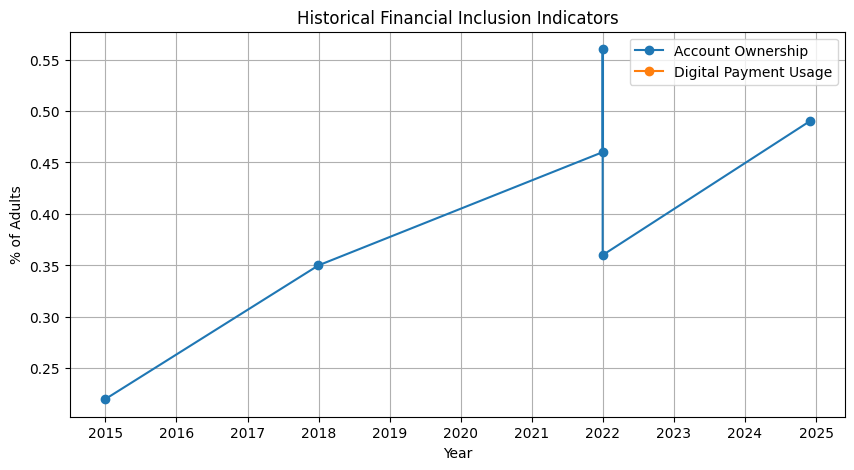

In [45]:
##
# define direct indicator 
##
# Filter target series
acc = observations[observations["indicator_code"]=="ACC_OWNERSHIP"].set_index("observation_date")["value_numeric"]
dp = observations[observations["indicator_code"]=="USG_DIGITAL_PAYMENT"].set_index("observation_date")["value_numeric"]

# how I make in pecentage
acc = acc / 100
dp = dp / 100
print("Target indicators filtered.")
print(f"Account Ownership data points: {len(acc)}")
print(f"Digital Payment Usage data points: {len(dp)}")

# Quick plot of historical trends
plt.figure(figsize=(10,5))
plt.plot(acc.index, acc.values, marker='o', label="Account Ownership")
plt.plot(dp.index, dp.values, marker='o', label="Digital Payment Usage")
plt.title("Historical Financial Inclusion Indicators")
plt.ylabel("% of Adults")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.show()

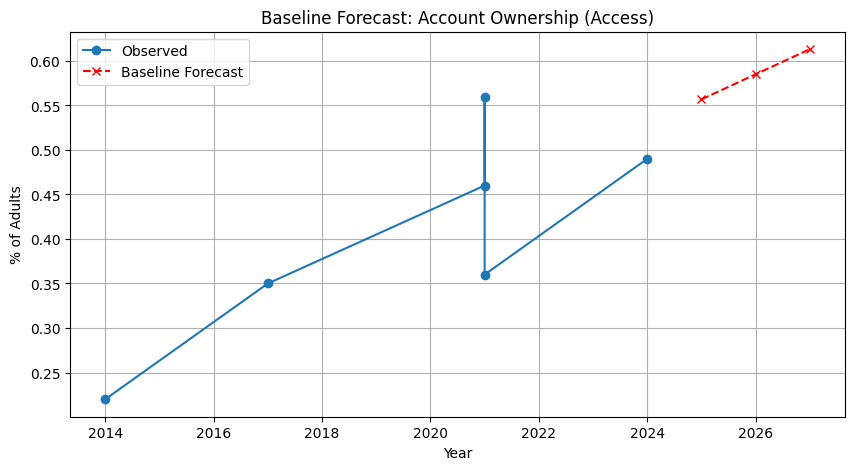

Forecast 2025-2027 (Account Ownership): [0.56 0.59 0.61]


In [46]:
##
# Baseline Forecast – Linear Trend
##
# Prepare data
acc_df = acc.reset_index()
acc_df["year"] = acc_df["observation_date"].dt.year

X_acc = acc_df["year"].values.reshape(-1,1)
y_acc = acc_df["value_numeric"].values

X_future = np.array([2025, 2026, 2027]).reshape(-1,1)

# Linear regression
lr_acc = LinearRegression()
lr_acc.fit(X_acc, y_acc)
acc_pred_baseline = lr_acc.predict(X_future)

# Plot
plt.figure(figsize=(10,5))
plt.plot(acc_df["year"], y_acc, marker='o', label="Observed")
plt.plot([2025, 2026, 2027], acc_pred_baseline, marker='x', linestyle='--', color='red', label="Baseline Forecast")
plt.title("Baseline Forecast: Account Ownership (Access)")
plt.ylabel("% of Adults")
plt.xlabel("Year")
plt.grid(True)
plt.legend()
plt.show()

print("Forecast 2025-2027 (Account Ownership):", acc_pred_baseline.round(2))

In [47]:
# Filter observations
acc = observations[observations["indicator_code"] == "ACC_OWNERSHIP"].copy()
dp = observations[observations["indicator_code"] == "USG_DIGITAL_PAYMENT"].copy()

# Ensure observation_date is datetime
acc["observation_date"] = pd.to_datetime(acc["observation_date"])
dp["observation_date"] = pd.to_datetime(dp["observation_date"])

# Aggregate by year (if data is daily or monthly)
acc_yearly = acc.groupby(acc["observation_date"].dt.year)["value_numeric"].mean()
dp_yearly = dp.groupby(dp["observation_date"].dt.year)["value_numeric"].mean()

# Convert to percentage if stored as fraction
if acc_yearly.max() <= 1:
    acc_yearly *= 100
if dp_yearly.max() <= 1:
    dp_yearly *= 100

# Combine into a single DataFrame
fi_rates = pd.DataFrame({
    "Account_Ownership_%": acc_yearly,
    "Digital_Payment_Usage_%": dp_yearly
})

print(fi_rates)

                  Account_Ownership_%  Digital_Payment_Usage_%
observation_date                                              
2014                             22.0                      NaN
2017                             35.0                      NaN
2021                             46.0                      NaN
2024                             49.0                      NaN


In [48]:
# Ensure the columns your function expects exist
impact_full.rename(columns={
    "related_indicator": "related_indicator_impact",
    "impact_magnitude": "impact_magnitude_impact",
    "impact_direction": "impact_direction_impact",
    "observation_date_event": "observation_date_event",
    "lag_months": "lag_months_impact"
}, inplace=True)
print("Impact links columns renamed for consistency.")

Impact links columns renamed for consistency.


In [59]:
##
# Event-Augmented Forecast
##
def apply_event_impact(series, events_df, indicator, col_map=None, forecast_years=[2025,2026,2027]):
    """
    col_map: dict mapping {'related_indicator':..., 'impact_magnitude':..., 'impact_direction':..., 'observation_date':..., 'lag_months':...}
    """
    if col_map is None:
        col_map = {
            "related_indicator":"related_indicator_impact",
            "impact_magnitude":"impact_magnitude_impact",
            "impact_direction":"impact_direction_impact",
            "observation_date":"observation_date_event",
            "lag_months":"lag_months_impact"
        }

    result = pd.Series(index=forecast_years, dtype=float)
    
    # Baseline trend
    last_year = series.index.year[-1]
    slope = (series.values[-1] - series.values[0]) / (series.index.year[-1] - series.index.year[0])
    for y in forecast_years:
        result[y] = series.values[-1] + slope * (y - last_year)
    
    # Apply events
    for _, row in events_df.iterrows():
        if row[col_map["related_indicator"]] != indicator:
            continue
        try:
            event_year = pd.to_datetime(row[col_map["observation_date"]]).year + int(row[col_map["lag_months"]]/12)
        except:
            continue
        for y in forecast_years:
            if y >= event_year:
                direction = 1 if row[col_map["impact_direction"]]=="positive" else -1
                magnitude = row[col_map["impact_magnitude"]]
                result[y] += magnitude * direction
    return result

In [60]:
def apply_event_impact(series, events_df, indicator, horizon=5):
    # Handle year extraction safely
    if isinstance(series.index, pd.DatetimeIndex):
        years = series.index.year
    else:
        years = series.index.astype(int)

    last_year = years[-1]
    first_year = years[0]

    forecast_years = range(last_year + 1, last_year + horizon + 1)
    result = pd.Series(index=forecast_years, dtype=float)

    # Baseline trend
    slope = (series.values[-1] - series.values[0]) / (last_year - first_year)

    for y in forecast_years:
        base_value = series.values[-1] + slope * (y - last_year)
        event_impact = events_df.loc[events_df["Year"] == y, indicator].sum()
        result[y] = base_value + event_impact

    return result

In [62]:
def scenario_forecast(base_forecast, events_df, indicator, scenario="base"):
    factor = 1.0
    if scenario == "optimistic": factor = 1.2
    if scenario == "pessimistic": factor = 0.8
    result = apply_event_impact(base_forecast, events_df, indicator) * factor
    return result

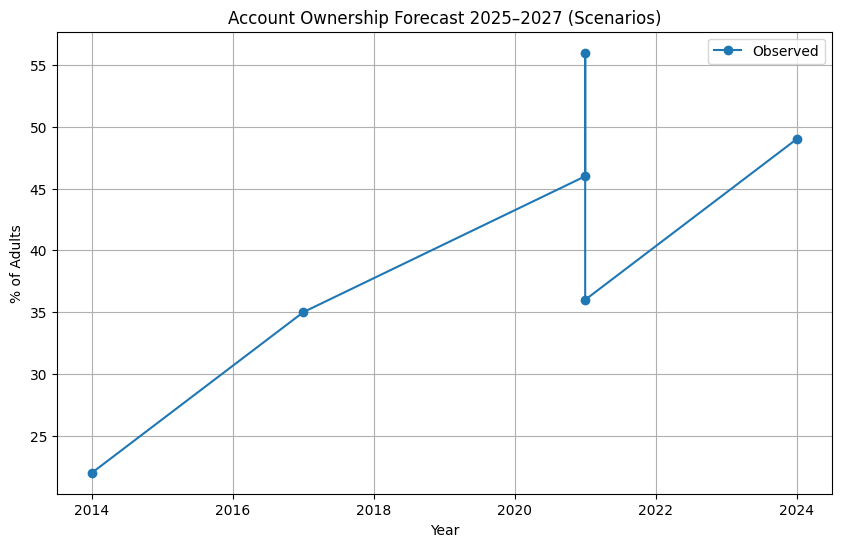

Forecast scenarios plotted.


In [64]:
acc = acc.set_index('observation_date')['value_numeric']
scenarios = ["base", "optimistic", "pessimistic"]
acc_years = acc.index.year  # converts to int year: 2011, 2014, etc.


plt.figure(figsize=(10,6))

# Observed
plt.plot(acc_years, acc.values, marker='o', label="Observed")

# Forecast scenarios
for scenario in forecast_scenarios.columns:  # e.g., ["base", "optimistic", "pessimistic"]
    plt.plot(
        forecast_scenarios.index,         # should be years: 2025, 2026, 2027
        forecast_scenarios[scenario].values,
        marker='x',
        linestyle='--',
        label=f"Forecast ({scenario})"
    )

plt.title("Account Ownership Forecast 2025–2027 (Scenarios)")
plt.xlabel("Year")
plt.ylabel("% of Adults")
plt.grid(True)
plt.legend()
plt.show()
print("Forecast scenarios plotted.")

Text(0.5, 1.0, 'Account Ownership Forecast with Uncertainty')

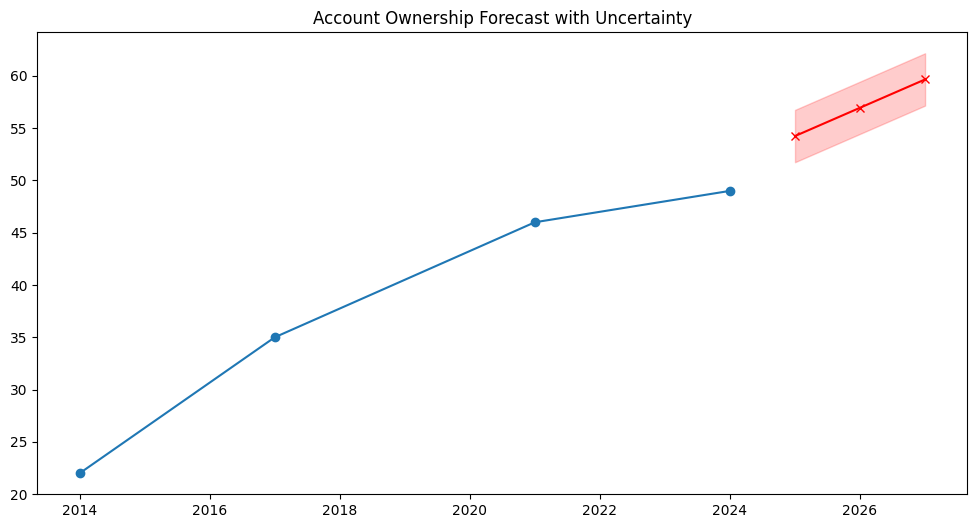

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Example for Account Ownership
years = np.array(acc_yearly.index).reshape(-1,1)
values = acc_yearly.values

model = LinearRegression().fit(years, values)
pred_years = np.array([2025,2026,2027]).reshape(-1,1)
pred = model.predict(pred_years)

# Simple approximation for +/- 1 standard deviation
residuals = values - model.predict(years)
std_dev = np.std(residuals)
lower = pred - std_dev
upper = pred + std_dev
plt.figure(figsize=(12,6))
plt.plot(years, values, label="Observed", marker='o')
plt.plot(pred_years, pred, label="Linear Trend Forecast", marker='x', color='red')
plt.fill_between(pred_years.flatten(), lower, upper, color='red', alpha=0.2, label="±1 Std Dev")
plt.title("Account Ownership Forecast with Uncertainty")

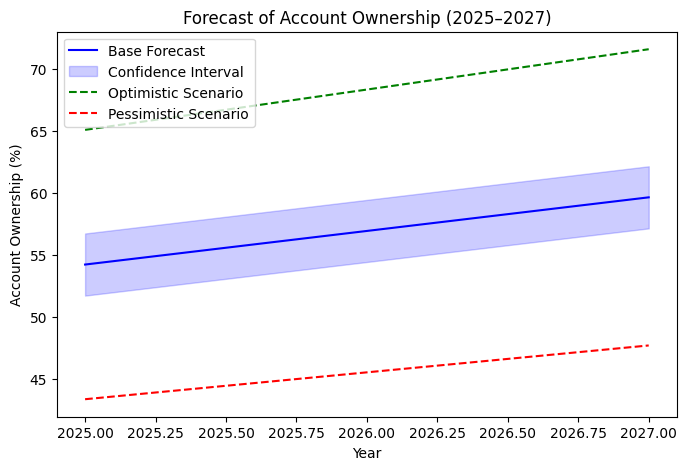

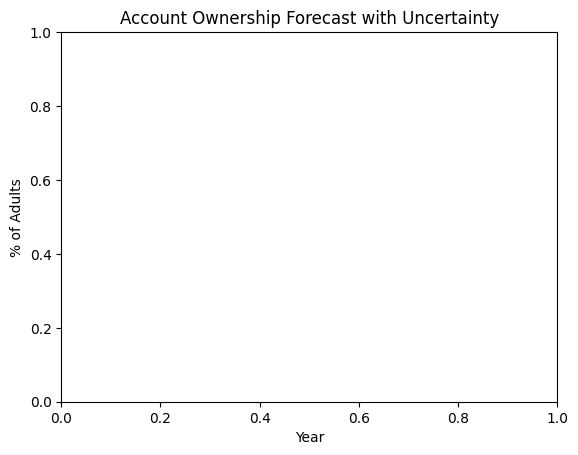

In [ ]:
# Plot forecast with uncertainty and scenarios
years = [2025,2026,2027]
plt.figure(figsize=(8,5))
plt.plot(years, pred, label="Base Forecast", color="blue")
plt.fill_between(years, lower, upper, color="blue", alpha=0.2, label="Confidence Interval")
plt.plot(years, pred*1.2, '--', label="Optimistic Scenario", color="green")
plt.plot(years, pred*0.8, '--', label="Pessimistic Scenario", color="red")
plt.ylabel("Account Ownership (%)")
plt.xlabel("Year")
plt.title("Forecast of Account Ownership (2025–2027)")
plt.legend()
plt.show()
plt.title("Account Ownership Forecast with Uncertainty")
plt.ylabel("% of Adults")
plt.xlabel("Year")
plt.xlabel("Year")
plt.show()

In [ ]:
# Save forecasts to CSV
forecast_scenarios.to_csv("../data/processed/ACC_OWNERSHIP_forecast_2025_2027.csv")
print("Forecasts saved to CSV.")

Forecasts saved to CSV.
